In [1]:
import shap
import numpy as np
import pandas as pd
import os
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.preprocessing import StandardScaler, RobustScaler
from skopt.space import Real, Integer
from skopt import BayesSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier as CBC
from sklearn.metrics import confusion_matrix
os.chdir(r'C:\Users\Bruger1\Documents\Data Science\Kandidatspeciale\Preprocessing\Data Description')

df = pd.read_csv('train_df_final.csv')

In [2]:
#list of categoricals for catboost, convert to integer 
disc_cols = df.columns[(df.apply(lambda x: x.dropna().astype(int) == x.dropna())).all() & (df.max() <= 5000) & (df.min() >= -251)]
cat_cols = disc_cols[(df[disc_cols].nunique() == 2)]
cat_cols = list(cat_cols)
df_cat = df[cat_cols]
df_cat = df_cat.dropna(axis=1, how='any')
df_cat = df_cat.drop(['target'], axis=1)
df_cat = pd.concat([df_cat, df['virksomhedsoplysninger_54']], axis=1)
int_cols = df_cat.dtypes[df_cat.dtypes=='int64'].index
df_cat=df_cat.astype('int64')

#checking 
print(df_cat.dtypes[df_cat.dtypes=='int64'].index)
#simpler way?
#################df_subset=df_subset.astype('int64')

#dropping from original 
df = df.drop(df_cat[df_cat.columns],axis=1)
#carrying a list of the categorical columns 
cat_cols = list(df_cat.columns)

Index(['ejerkreds_aktiv_35', 'ejerkreds_aktiv_39', 'ejerkreds_aktiv_42',
       'ejerkreds_aktiv_45', 'ejerkreds_aktiv_51', 'ejerkreds_aktiv_92',
       'ejerkreds_aktiv_94', 'ejerkreds_aktiv_99', 'ejerkreds_ny_33',
       'ejerkreds_ny_34', 'adresse_1', 'adresse_16', 'risikomarkering_2',
       'risikomarkering_3', 'risikomarkering_5', 'risikomarkering_7',
       'risikomarkering_8', 'risikomarkering_10', 'risikomarkering_11',
       'risikomarkering_12', 'risikomarkering_13', 'risikomarkering_14',
       'risikomarkering_16', 'risikomarkering_17', 'risikomarkering_18',
       'risikomarkering_19', 'risikomarkering_20', 'risikomarkering_21',
       'risikomarkering_23', 'sagsoplysninger_3', 'sagsoplysninger_5',
       'sagsoplysninger_6', 'sagsoplysninger_7', 'sagsoplysninger_9',
       'sagsoplysninger_10', 'sagsoplysninger_11', 'sagsoplysninger_16',
       'sagsoplysninger_17', 'sagsoplysninger_18', 'sagsoplysninger_19',
       'sagsoplysninger_20', 'sagsoplysninger_21', 'sagsoplysn

In [3]:
##################################  Preparing variables for discretization 
# select columns where all the non-NaN values have no decimal places
disc_cols = df.columns[(df.apply(lambda x: x.dropna().astype(int) == x.dropna())).all() & (df.max() <= 5000) & (df.min() >= -251)]
# convert the lists to sets and take the set difference

disc_cols = disc_cols[~(df[disc_cols].nunique() == 2)]
disc_cols = disc_cols[(df[disc_cols].nunique() >4)]
disc_cols = list(disc_cols)
vars_to_exclude = ['risikomarkering_count', 'virksomhedsoplysninger_54', 'virksomhedsoplysninger_55']
vars_to_add = ['ejerkreds_aktiv_5']
disc_cols = [col for col in disc_cols if col not in vars_to_exclude] + vars_to_add
df_disc = df[disc_cols]
df_disc = df_disc.dropna(axis=1, how='any')
disc_cols = list(df_disc.columns)

In [4]:
############################ Defining training set splits - 
#adding categoricals back to df 
df = pd.concat([df, df_cat],axis=1)

y_train = df['target']
X_train = df.drop(['target'],axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify = y_train, random_state=41)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, stratify = y_train,  random_state=41)

In [5]:
######### Binnin Variables 
def bin_variables(df, var_list, bins_dict):
    """
    Bins the variables in a DataFrame based on custom bin sizes specified in a dictionary.

    Args:
        df (pandas.DataFrame): The DataFrame containing the variables to be binned.
        bins_dict (dict): A dictionary containing variable names as keys and bin sizes as values.

    Returns:
        pandas.DataFrame: A new DataFrame with the binned variables.
    """
    binned_df = df.copy()
    for var in var_list:
        if var in bins_dict:
            bins = bins_dict[var]
            binned_df[var] = pd.cut(binned_df[var], bins, labels=False, include_lowest=True)
    return binned_df

bins_dict = { ########### cuz trees like categories - univariate splits 
    
             'ejerkreds_aktiv_5': [1, 300, 689, 1192, 1795, 2955],
             'ejerkreds_aktiv_6': [1, 17, 110, 474.5, 4870], 
             'ejerkreds_aktiv_7': [1, 256, 988, 2585, 4882],
             'ejerkreds_aktiv_9': [-319, -6, 0, 3, 187],
             'ejerkreds_aktiv_19': [0, 36.68, 108.67, 315.89, 1599],
             'ejerkreds_aktiv_25': [-27092,-25566, -25559,-25524,-25214],
             'ejerkreds_aktiv_26': [-27420,-25566, -25560,-25527,-25214],
             'ejerkreds_aktiv_83': [0, 1.4, 2, 2.8, 4.8], #time based, however, very small interval 
             
             'virksomhedsoplysninger_14': [-251, 1, 9, 48, 300],
             'virksomhedsoplysninger_15': [-27, 9, 24, 48, 294],
             'virksomhedsoplysninger_16': [-251, 1, 4, 15.5, 240],
             'virksomhedsoplysninger_18': [1, 3, 13, 56, 352],
             'virksomhedsoplysninger_19': [1, 21, 55, 96.5, 272],
             'virksomhedsoplysninger_23': [0, 30.69, 62.94, 134.81, 1540.18],
             'virksomhedsoplysninger_29': [1, 19.75, 27, 44.75, 138],
             'virksomhedsoplysninger_31': [5, 11, 17, 18, 19],
             
             'sagsoplysninger_2': [-361, -20, -5, 0, 251],
   
             'ejerkreds_aktiv_1': [0, 0.5, 1, 77, 294, 2955],
             'ejerkreds_aktiv_2': [0, 0.5, 1, 23], 
             'ejerkreds_aktiv_3': [0, 0.5, 1, 74, 173],
             'ejerkreds_aktiv_4': [0, 0.5, 1, 74, 266],
             'ejerkreds_aktiv_12': [0, 0.5, 1, 44, 92],
             'ejerkreds_aktiv_31': [0, 0.5, 1, 23.73,970, 2381],
             'ejerkreds_aktiv_34': [0, 1, 3, 7],
             'ejerkreds_aktiv_36': [0, 0.5, 1, 3, 8],
             'ejerkreds_aktiv_37': [0, 0.5, 1, 2, 7], 
             'ejerkreds_aktiv_38': [0, 0.5, 1, 3, 14],
             'ejerkreds_aktiv_40': [0, 0.5, 1, 2, 10],
             'ejerkreds_aktiv_41': [0, 0.5, 1, 42, 178],
             'ejerkreds_aktiv_44': [0, 0.5, 1, 14, 81, 112], 
             'ejerkreds_aktiv_46': [0, 0.5, 1, 8, 51],
             'ejerkreds_aktiv_47': [1, 28.5, 244, 858, 2766],
             'ejerkreds_aktiv_48': [1, 9.5, 180, 955],
             'ejerkreds_aktiv_49': [1, 8.95, 177, 917], 
             'ejerkreds_aktiv_50': [0, 1, 10, 177, 985], 
             'ejerkreds_aktiv_75': [0, 1, 56, 77],
             'ejerkreds_aktiv_76': [0, 1, 51, 82],
             'ejerkreds_aktiv_78': [0, 0.5, 1, 2, 7],
             'ejerkreds_aktiv_80': [0, 1, 2, 5],
             'ejerkreds_aktiv_96': [0, 1, 10, 519, 853, 2529],
             'ejerkreds_aktiv_97': [0, 1, 30, 60, 81],
             'ejerkreds_aktiv_102': [0, 1, 2, 8], 
             'ejerkreds_aktiv_126': [0, 1, 2, 44, 92],
             'ejerkreds_aktiv_127': [0, 1, 2, 5],
             'ejerkreds_aktiv_129': [0, 1, 2, 5],
             'ejerkreds_aktiv_130': [0, 1, 13, 21], 
             
             'ejerkreds_ny_8': [0, 1, 2.85, 78, 188, 312],
             'ejerkreds_ny_47': [0, 1, 6, 37],
             'virksomhedsoplysninger_5': [0, 0.5, 1, 2, 18],
             'virksomhedsoplysninger_6': [0, 0.5, 1, 3, 18],
             'virksomhedsoplysninger_17': [0, 1, 1.95, 13, 19],

             'adresse_2':[0, 1.573, 62, 560],
             'adresse_3':[0, 1.423, 60, 560],
             'adresse_4':[0, 1.398, 56, 560],
             'adresse_5':[0, 0.265, 1, 38, 328],
             'adresse_6':[0, 0.03, 1, 2, 8],
             'adresse_7':[0, 0.29, 1, 23, 60],
             'adresse_8':[0, 0.265, 1, 7],
             'adresse_9':[0, 0.016, 1, 3],
             'adresse_10':[0, 0.08, 1, 11, 70],
             'adresse_11':[0, 0.002, 1, 11],
             'adresse_12':[0, 0.008, 1, 2, 8, 57],
             'adresse_13':[0, 0.014, 4],
             'adresse_14':[0, 0.01, 60, 560],
             'adresse_15':[0, 2.5, 56, 560],

             }

X_train = bin_variables(X_train, X_train.columns, bins_dict)
X_test = bin_variables(X_test, X_test.columns, bins_dict)
X_val = bin_variables(X_val, X_val.columns, bins_dict)

In [6]:
X_train_disc = X_train[disc_cols + cat_cols]
X_train = X_train.drop(columns=disc_cols+cat_cols)

X_test_disc = X_test[disc_cols + cat_cols]
X_test = X_test.drop(columns=disc_cols+cat_cols)

X_val_disc = X_val[disc_cols + cat_cols]
X_val = X_val.drop(columns=disc_cols+cat_cols)

#Scaling Data 
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X_train = pd.concat([X_train, X_train_disc],axis=1)
X_test = pd.concat([X_test, X_test_disc],axis=1)
X_val = pd.concat([X_val, X_val_disc],axis=1)

In [12]:
class_weight0 = 13719/(2*10335)
class_weight1 = 13719/(2*3384)
class_weights = np.array([class_weight0, class_weight1])

from catboost import Pool
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_cols)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols)

model = CBC(class_weights=class_weights, iterations=138, cat_features=cat_cols, learning_rate=0.10005057882519877, od_type="Iter", od_wait=100, random_state = 42000,
            max_depth=16, colsample_bylevel=0.5, subsample=0.7753, bagging_temperature=0.0,
            random_strength=1, one_hot_max_size=25, reg_lambda=36.966)
cat_model = model.fit(train_pool)
y_hat = model.predict(val_pool)

print(classification_report(y_val, y_hat))

0:	learn: 0.6744324	total: 2.3s	remaining: 5m 14s
1:	learn: 0.6550153	total: 2.37s	remaining: 2m 41s
2:	learn: 0.6393266	total: 4.85s	remaining: 3m 38s
3:	learn: 0.6262621	total: 7.38s	remaining: 4m 7s
4:	learn: 0.6146753	total: 10.1s	remaining: 4m 29s
5:	learn: 0.6034233	total: 13s	remaining: 4m 45s
6:	learn: 0.5935561	total: 15.3s	remaining: 4m 46s
7:	learn: 0.5852312	total: 17.8s	remaining: 4m 49s
8:	learn: 0.5779839	total: 20s	remaining: 4m 46s
9:	learn: 0.5701673	total: 22.3s	remaining: 4m 45s
10:	learn: 0.5623619	total: 24.9s	remaining: 4m 47s
11:	learn: 0.5561015	total: 27.5s	remaining: 4m 48s
12:	learn: 0.5488209	total: 29.9s	remaining: 4m 47s
13:	learn: 0.5434548	total: 33s	remaining: 4m 52s
14:	learn: 0.5377310	total: 35.4s	remaining: 4m 49s
15:	learn: 0.5316585	total: 38s	remaining: 4m 49s
16:	learn: 0.5276563	total: 40.5s	remaining: 4m 48s
17:	learn: 0.5230220	total: 42.8s	remaining: 4m 45s
18:	learn: 0.5191296	total: 45s	remaining: 4m 41s
19:	learn: 0.5156800	total: 47.4s	

Good Tax Payer Detected (True Negatives):  1246
Good Tax Payer Incorrectly Detected as Fraud (False Positives):  304
Fraudulent Tax Payer Not Detected (False Negatives):  172
Fraudulent Tax Payer Detected (True Positives):  336
Total Companies Deemed Fraudulent:  508


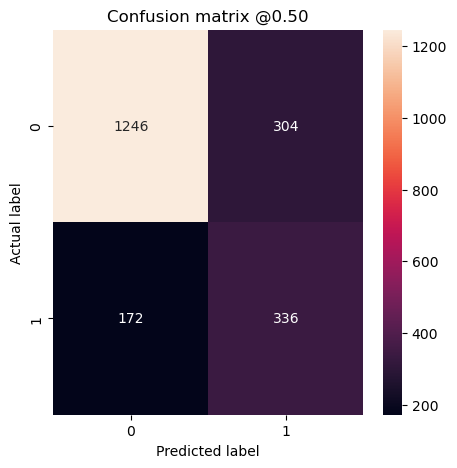

In [14]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Good Tax Payer Detected (True Negatives): ', cm[0][0])
  print('Good Tax Payer Incorrectly Detected as Fraud (False Positives): ', cm[0][1])
  print('Fraudulent Tax Payer Not Detected (False Negatives): ', cm[1][0])
  print('Fraudulent Tax Payer Detected (True Positives): ', cm[1][1])
  print('Total Companies Deemed Fraudulent: ', np.sum(cm[1]))
  
plot_cm(y_val, y_hat)

Explainer expected value: 0.02535466797831843


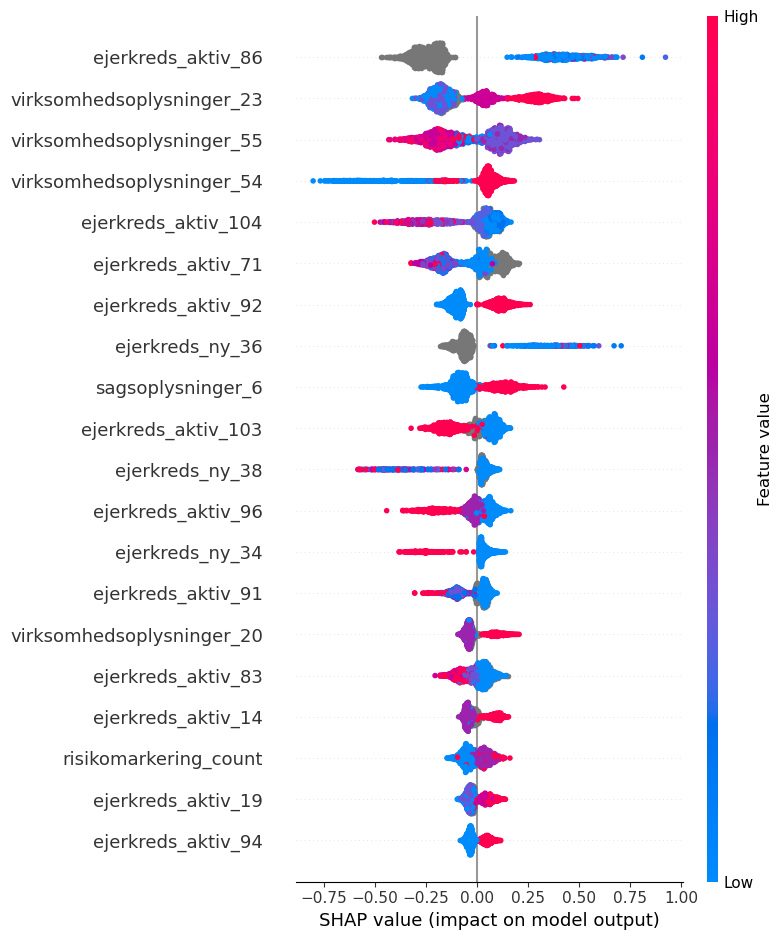

In [15]:
import warnings
explainer =  shap.Explainer(model, feature_names=X_val.columns)  #shap.TreeExplainer(Cat_model)
shap_values = explainer(val_pool)

expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

shap.summary_plot(shap_values, features=X_val)

Almost all Catboost models I ran on this dataset, have selected ejerkreds_aktiv_86 as the number 1 or like in this case, number 2 most significant feature in terms of how it impacts the model predictions. Same goes for variables like ejerkreds_aktiv_71 and virksomhedsoplysninger_54+55+23. 

Can we consider the model competent in its ability to evaluate what is truly important for the task? The confusion matrices does reveal somewhat competence in terms of the negative class, but not really so for the positive class. So, to build on our analysis, we want to extract some confidence estimates.

Ideally, we would traverse the Catboost model architecture, calculate the gini impurities of the leaf nodes, and then extract the associated feature splits that leads to the purest nodes. CatBoost does not provide scikit-like functionality, that more easily enables one to do this.

So, i propose a compromise. We use the few functionalities catboost does provide: calculate_leaf_indexes, this returns the exact leaf node each prediction i ends up in, after j-th iteration. Hence, we can access the final leaf node, calculate the class distribution and then calculate the gini impurities for the final leaf nodes. A compromise to extracting the exact feature splits in the tree of the pure nodes, then, is to use SHAP decision plots to see which features had the most impact on the most pure nodes, as given by our calculation of gini impurities. This should help us identify which features are associated with the highest quality decision rules. 

In [17]:
y_val = y_val.reset_index(drop=True)

In [18]:
################ Gini Impurity and Decision Rules 

# Get predicted class probabilities and leaf node indices for each observation
leaf_indices = model.calc_leaf_indexes(X_val, ntree_start=0, ntree_end=0, thread_count=-1)
class_probs = model.predict_proba(X_val)

# Calculate gini impurity for each leaf node
num_classes = 2
unique_leaf_indices, leaf_counts = np.unique(leaf_indices, return_counts=True)


gini_impurities = np.zeros(len(unique_leaf_indices))
for i, leaf_index in enumerate(unique_leaf_indices):
    # Get the indices of the observations in the leaf node
    leaf_indices_in_node = np.where(np.isin(leaf_indices, leaf_index))[0]
    # Calculate the class distribution in the leaf node
    #class_distribution = np.bincount(y_val[leaf_indices_in_node], minlength=num_classes)
    class_distribution = np.bincount(y_val[leaf_indices_in_node].values, minlength=num_classes)

    # Calculate the gini impurity
    gini_impurity = 1 - np.sum(np.square(class_distribution / np.sum(class_distribution)))
    gini_impurities[i] = gini_impurity

# Create dictionary mapping leaf node index to gini impurity value
leaf_index_to_gini_dict = dict(zip(unique_leaf_indices, gini_impurities))

# Get the index of the final leaf node for each observation
leaf_indices_preds = leaf_indices[:, -1]

# Look up the gini impurity value for each leaf node index in last iteration
gini_impurities_preds = [leaf_index_to_gini_dict[idx] for idx in leaf_indices_preds]

# Add the Gini index to the dataframe of predicted probabilities
class_probs = pd.DataFrame(class_probs, columns=['class_0', 'class_1'])
class_probs['leaf_gini'] = gini_impurities_preds #impurity of the leaf node the prediction belongs to 
class_probs['leaf_indices'] = leaf_indices_preds #index of last leaf per prediction
class_probs['predicted'] = y_hat #predicted class
class_probs['target'] = y_val #true class

In [19]:
class_probs.head()

,class_0,class_1,leaf_gini,leaf_indices,predicted,target
0,0.774455,0.225545,0.367189,35328,0,0
1,0.935020,0.064980,0.375000,656,0,0
2,0.427761,0.572239,0.364185,16384,1,1
3,0.561123,0.438877,0.409403,32768,0,0
4,0.758908,0.241092,0.444444,18520,0,0


We have the model probability estimates, we have the SHAP values for how much each feature contributes to the model decision, and we have our confidence estimate (gini impurity). While at this point, this was not our very best model, it was performing similarly to all the previous ones. Plotting the probability estimates of our model, with the gini impurity, reveals a spurious relationship between the certainty the model put in its predictions and the gini impurity

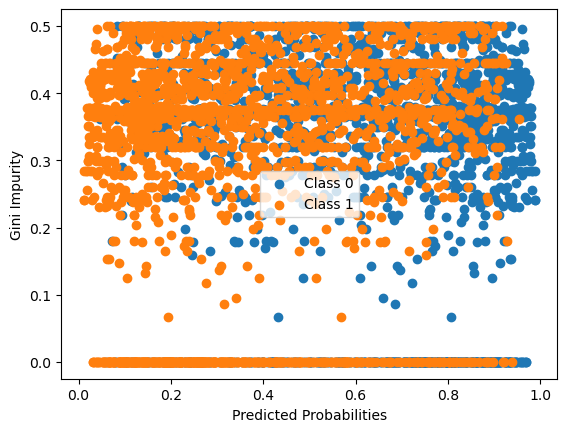

In [20]:

import matplotlib.pyplot as plt

# Create a scatter plot with class 0 probabilities and corresponding gini impurities
plt.scatter(class_probs.iloc[:, 0], class_probs['leaf_gini'], label='Class 0', alpha=1)

# Add class 1 probabilities and corresponding gini impurities to the same plot
plt.scatter(class_probs.iloc[:, 1], class_probs['leaf_gini'], label='Class 1', alpha=1)

# Add labels and legend to the plot
plt.xlabel('Predicted Probabilities')
plt.ylabel('Gini Impurity')
plt.legend()
plt.show()

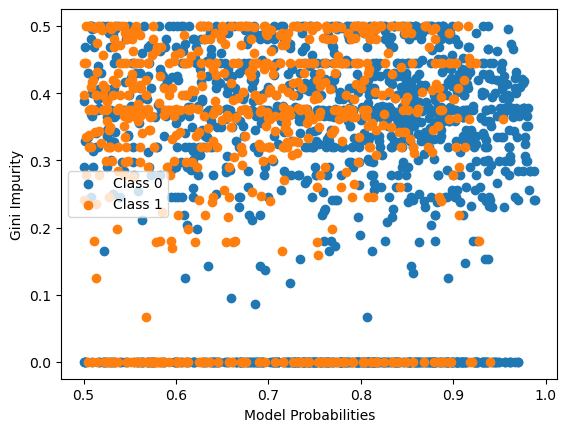

In [21]:
import matplotlib.pyplot as plt

# Select points with predicted probability greater than 0.5 for class 0
class_0_probs = class_probs[class_probs.iloc[:, 0] > 0.5]
class_0_gini = class_0_probs['leaf_gini']

# Select points with predicted probability greater than 0.5 for class 1
class_1_probs = class_probs[class_probs.iloc[:, 1] > 0.5]
class_1_gini = class_1_probs['leaf_gini']

# Create a scatter plot with filtered data
plt.scatter(class_0_probs.iloc[:, 0], class_0_gini, label='Class 0', alpha=1)
plt.scatter(class_1_probs.iloc[:, 1], class_1_gini, label='Class 1', alpha=1)

# Add labels and legend to the plot
plt.xlabel('Model Probabilities')
plt.ylabel('Gini Impurity')
plt.legend()
plt.show()


As we can see above, there is a spurious relationship between high model probability estimates, and our confidence estimate, gini impurity. The lower the gini impurity, the more certain we can be in our model predictions. In general, we can see that the model is usually more confident, places a higher probability, with the negative class.

# SHAP Decision Plots

In [53]:
leaf_indices = model.calc_leaf_indexes(X_val, ntree_start=0, ntree_end=0, thread_count=-1)
leaf_index_to_gini_dict = dict(zip(unique_leaf_indices, gini_impurities))
leaf_indices_preds = leaf_indices[:, -1]

[ 8192     0     0     0  4096     0     0     4     0   576     0     0
     0     0 16896     0 16384     0     0   512     0   256     0     0
     0     0     0    16     0 20480     0     0     0     0  8192     0
     0     0  1028     0     8     0   128    64     8  1088     0  1024
     0  4096  4096     0    32     0     0  2048    64     0  2048    16
  4128     0    32     8     0     0     0   128   512     0  1024     0
     0     0     0     0     0     0     1   512  2048     0     0    64
     0     0     0     0     0     0     0     0     0     0     0  4096
    64     0     0     2     8     0     0  1024     0     0   256    16
     0     0     0     0     0  2056  4096     0     0     0     0  1024
     0     0  8224     0     4     0     0     0     0     0     0    32
     2     0     0     0     0     1     0  4128    16     0  1024     0
    16  1024     0]


In [57]:
# Find the minimum impurity value in the leaf_index_to_gini_dict
min_impurity = min(leaf_index_to_gini_dict.values())

# Find the leaf nodes with the minimum impurity value
min_impurity_leaf_indices = [k for k, v in leaf_index_to_gini_dict.items() if v == min_impurity]

print("Minimum impurity value:", min_impurity)
print("Leaf indices with minimum impurity:", min_impurity_leaf_indices)


Minimum impurity value: 0.0
Leaf indices with minimum impurity: [23, 27, 31, 57, 58, 60, 78, 91, 92, 109, 142, 143, 151, 158, 165, 171, 175, 177, 178, 179, 181, 182, 186, 188, 197, 201, 202, 211, 214, 216, 218, 225, 228, 230, 240, 242, 252, 275, 277, 278, 279, 282, 284, 285, 286, 287, 291, 295, 302, 305, 308, 310, 313, 325, 329, 333, 334, 339, 341, 342, 345, 348, 351, 353, 355, 357, 360, 362, 363, 364, 365, 366, 368, 370, 378, 391, 395, 406, 408, 410, 418, 420, 428, 429, 430, 436, 440, 449, 454, 458, 460, 474, 488, 492, 496, 531, 533, 549, 557, 565, 570, 587, 589, 595, 598, 599, 604, 612, 613, 619, 620, 625, 626, 627, 649, 661, 663, 664, 665, 668, 673, 677, 681, 686, 691, 693, 694, 696, 700, 707, 708, 726, 728, 732, 733, 737, 738, 739, 740, 746, 750, 752, 773, 777, 782, 788, 789, 794, 801, 802, 808, 810, 824, 840, 844, 848, 849, 850, 852, 865, 866, 874, 899, 901, 902, 908, 910, 914, 915, 916, 918, 919, 924, 929, 930, 931, 932, 940, 944, 963, 964, 972, 976, 992, 993, 995, 1029, 1035, 10

In [63]:
# Get the leaf indices for the last iteration
leaf_indices_last_iter = leaf_indices[:, -1]
# Find the pure leaf indices at the last iteration
pure_leaf_indices_preds = np.array([leaf_index for leaf_index in purest_leaf_indices if leaf_index in leaf_indices_last_iter])

# Subset leaf_indices to only include rows for pure nodes at the last iteration
pure_leaf_indices_rows_preds = np.isin(leaf_indices_preds, pure_leaf_indices_preds)
pure_leaf_indices_rows_preds = leaf_indices_preds[pure_leaf_indices_rows_preds]

# Keep track of the original index values
original_indices_preds = X_val.index[pure_leaf_indices_rows_preds]

# Make SHAP decision plots for the pure predictions 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

print(purest_leaf_indices)
print(pure_leaf_indices_preds)

(array([5], dtype=int64),)
[]


In [22]:
# Get the leaf nodes for the last iteration
leaf_indices_last_iter = leaf_indices[:, -1]

# Compute the impurity values for the last iteration leaves
last_iteration_impurities = [leaf_index_to_gini_dict[node] for node in leaf_indices_last_iter]


# Find the leaf nodes with the 20 lowest impurity values
lowest_impurity_leaves = np.argsort(last_iteration_impurities)[:20]

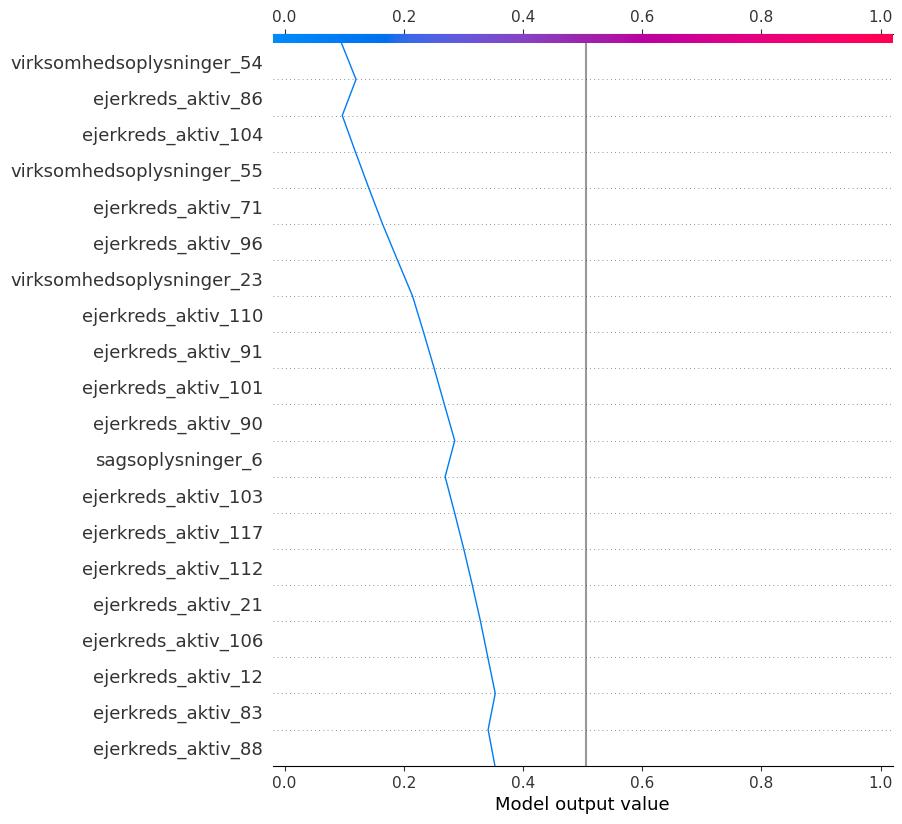

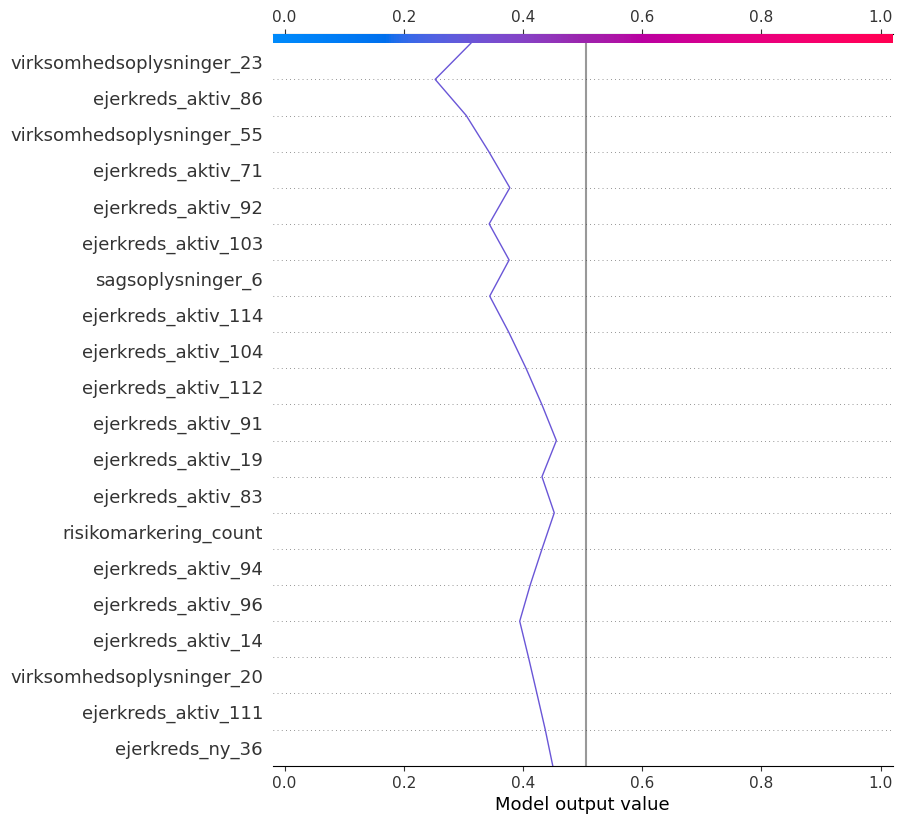

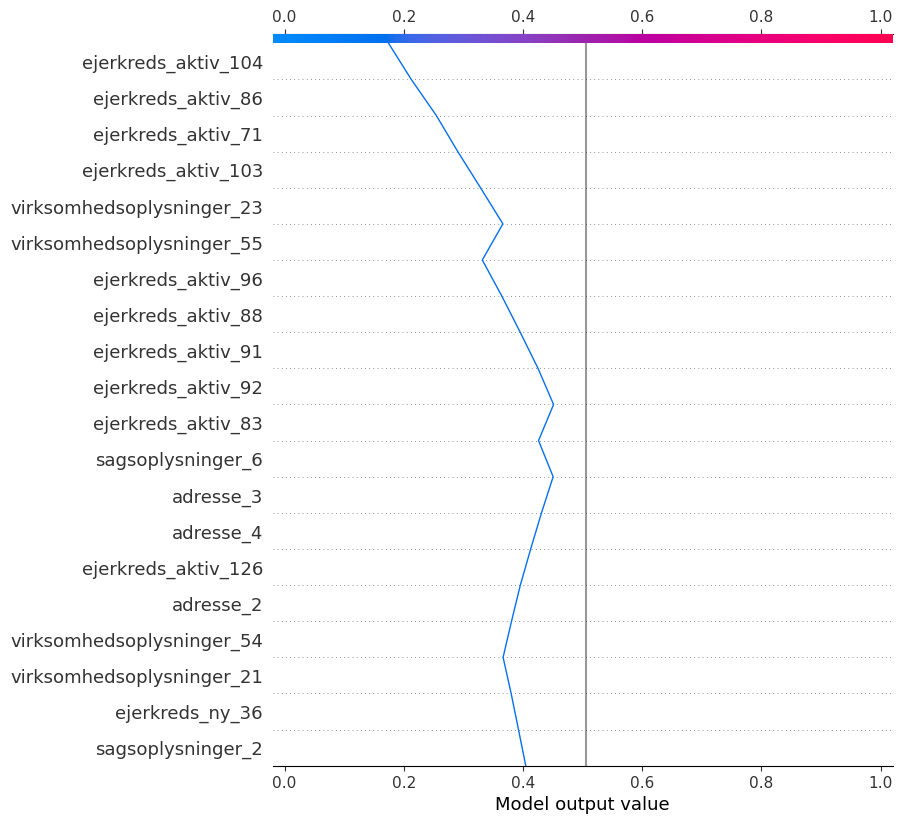

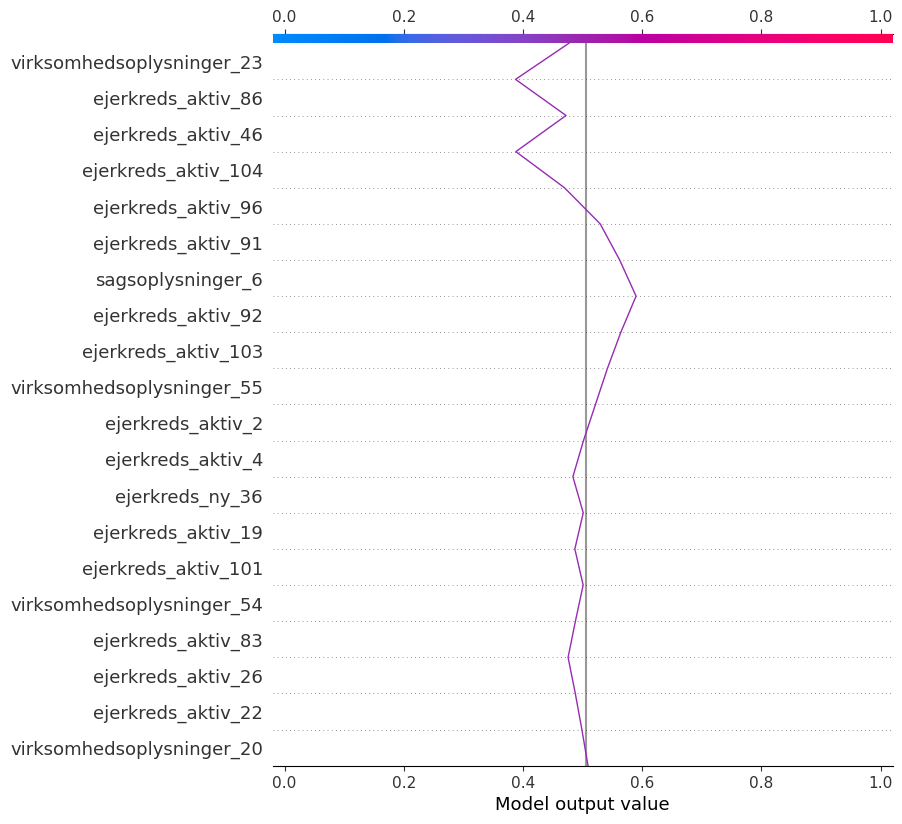

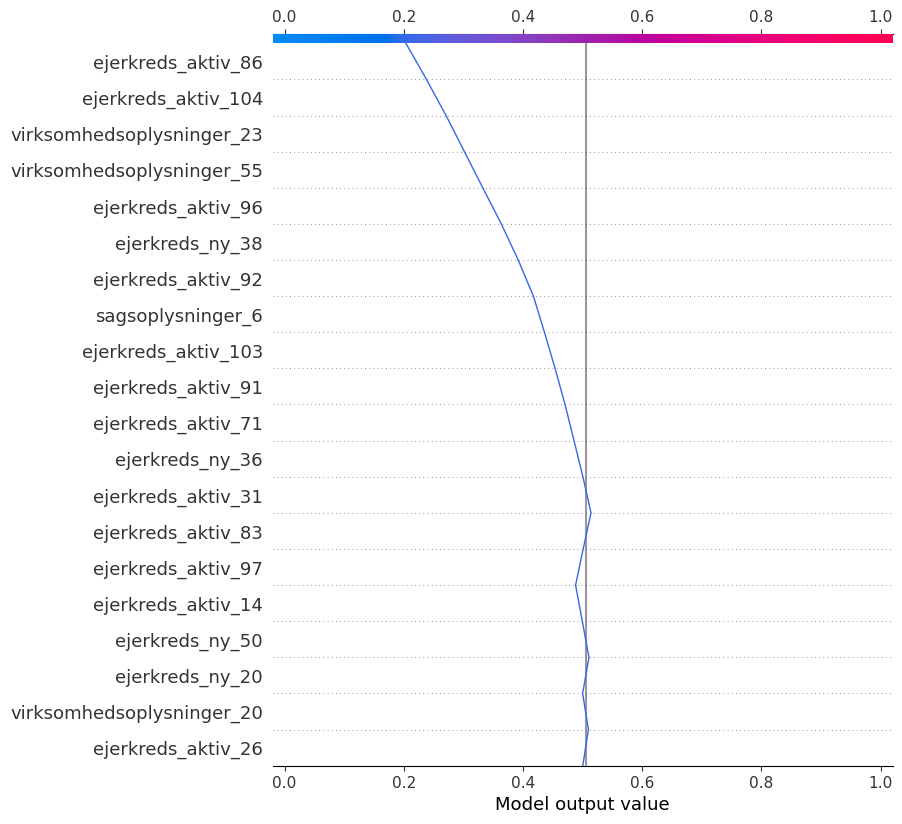

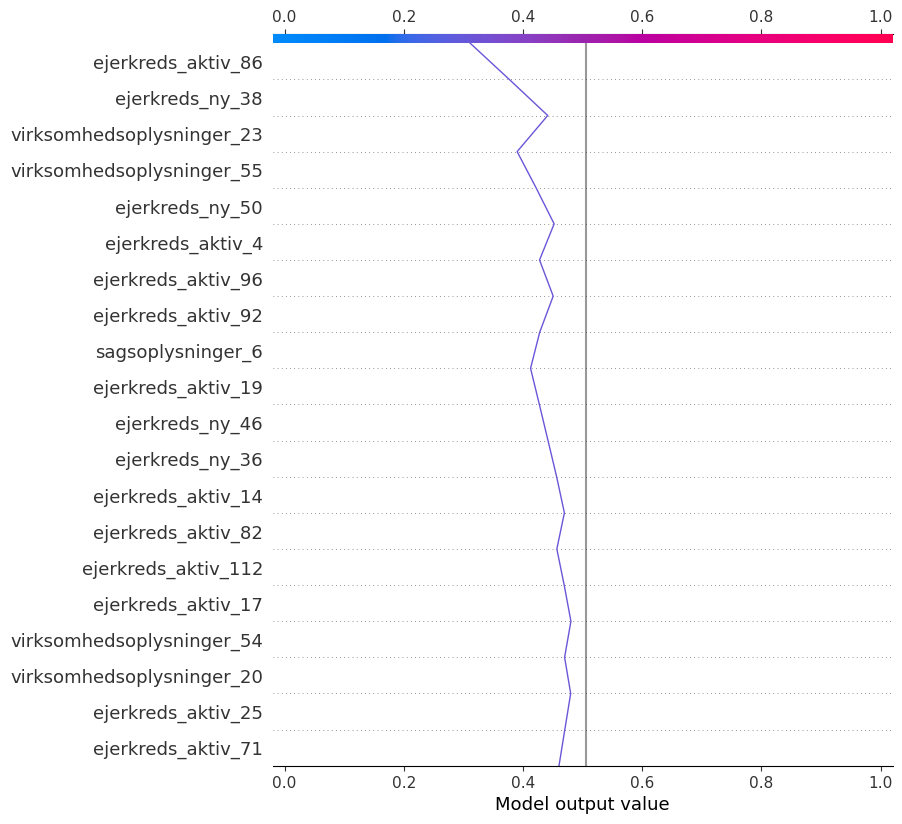

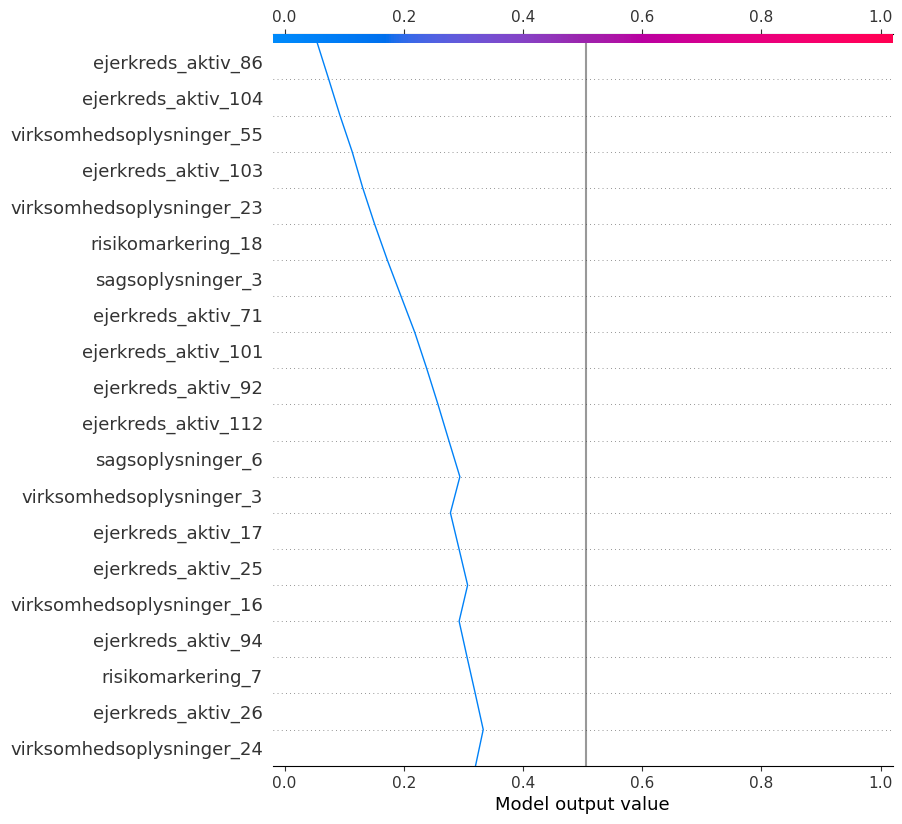

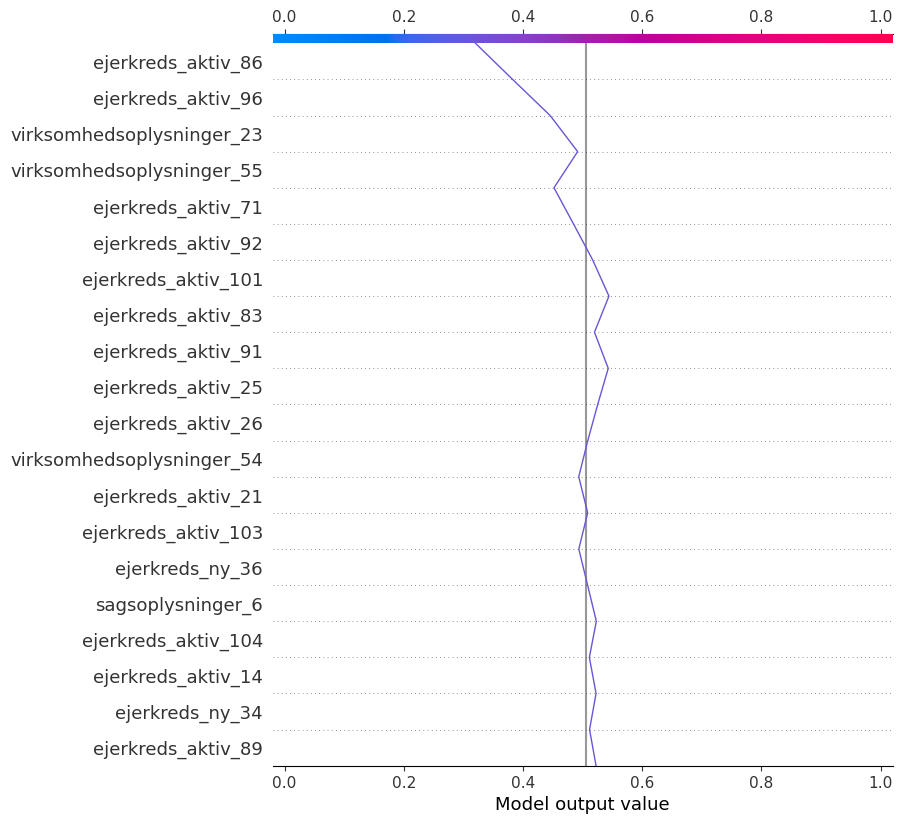

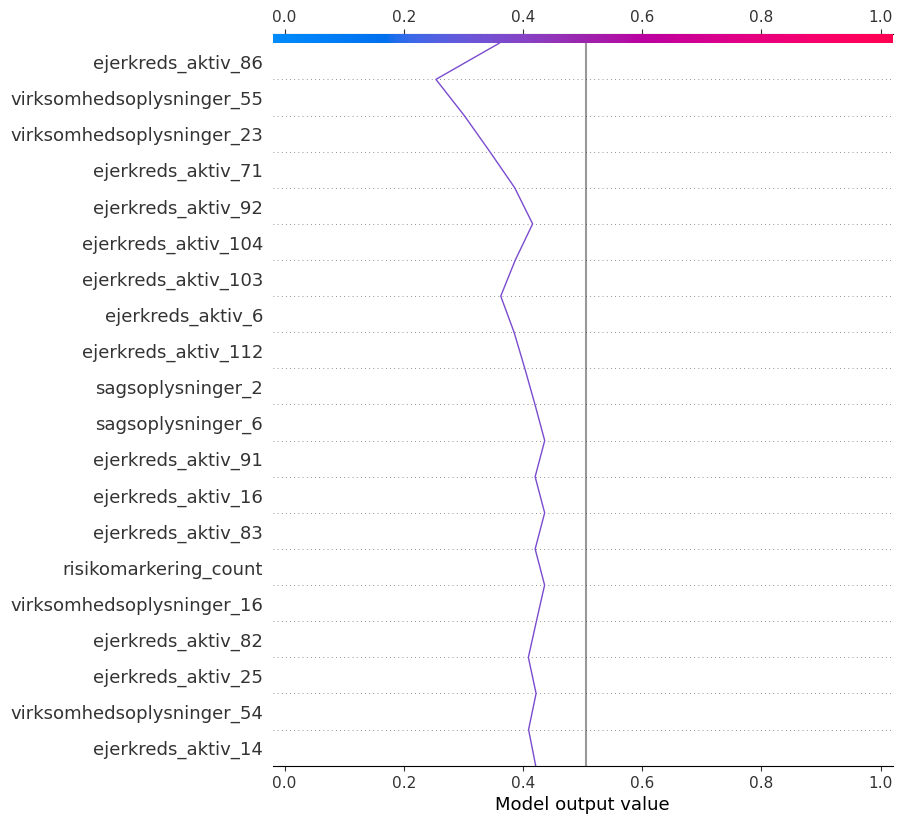

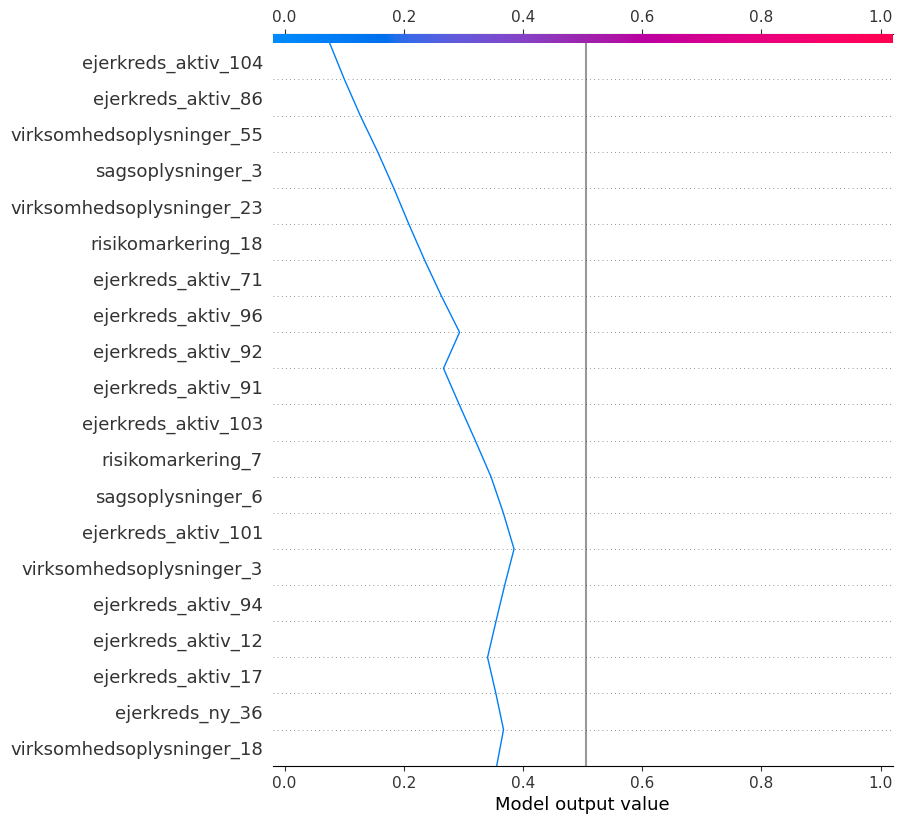

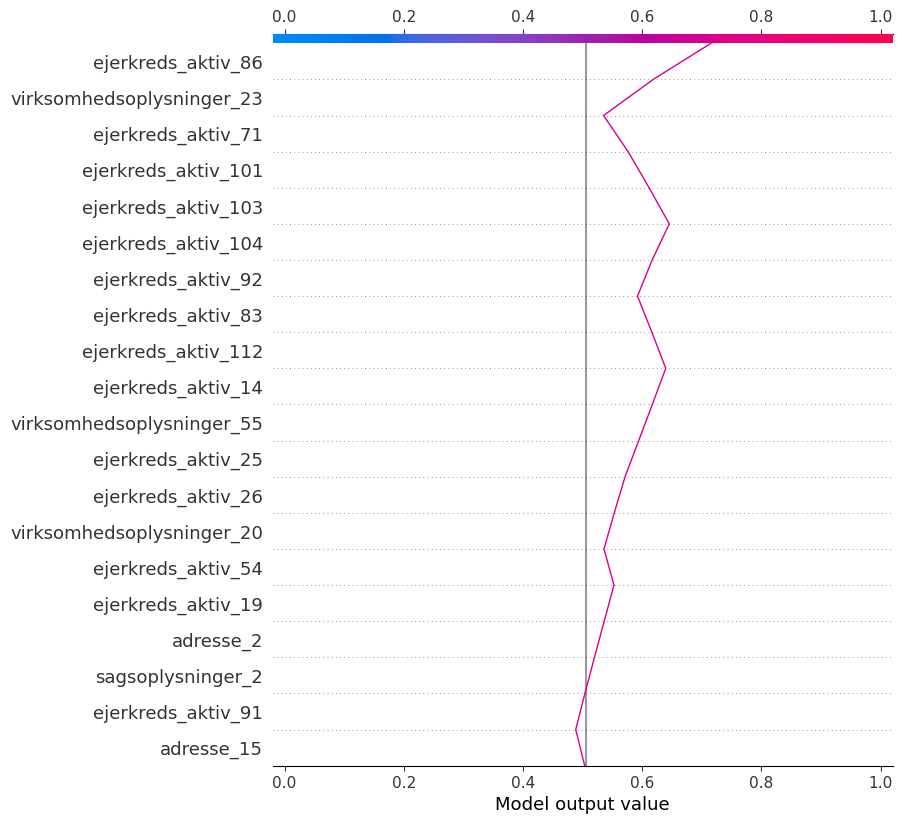

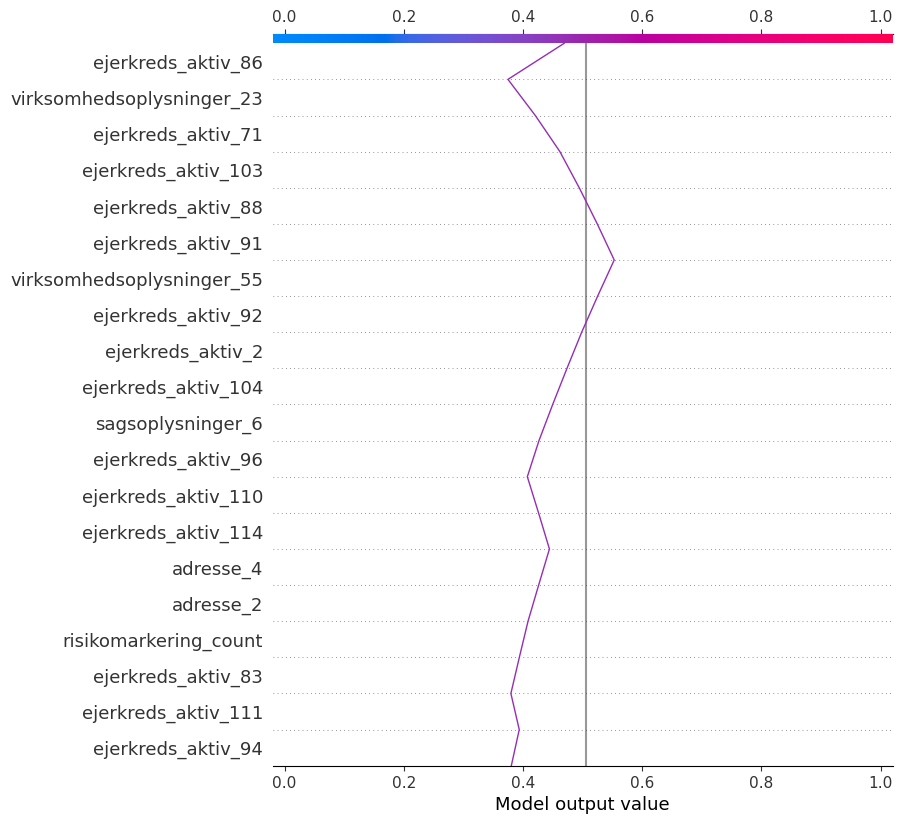

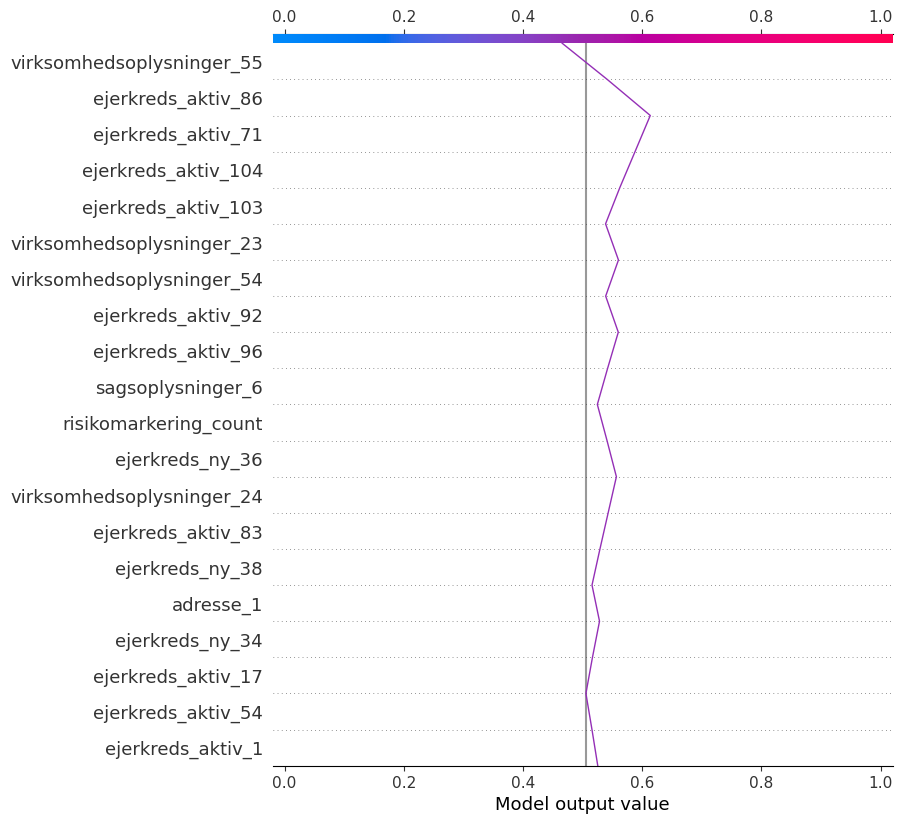

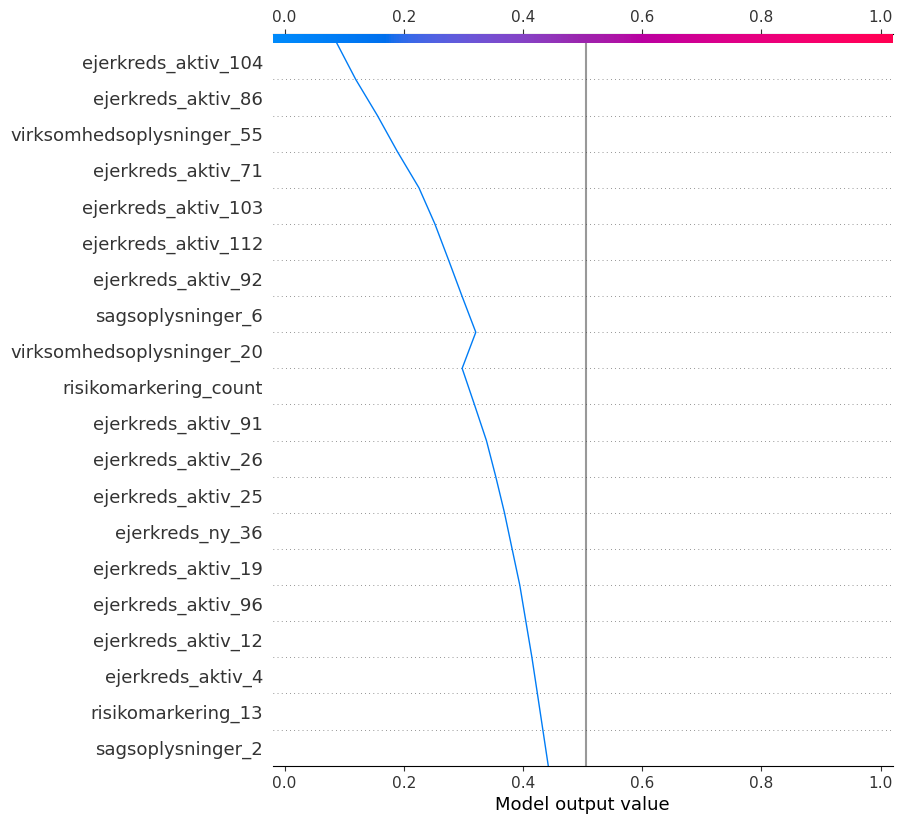

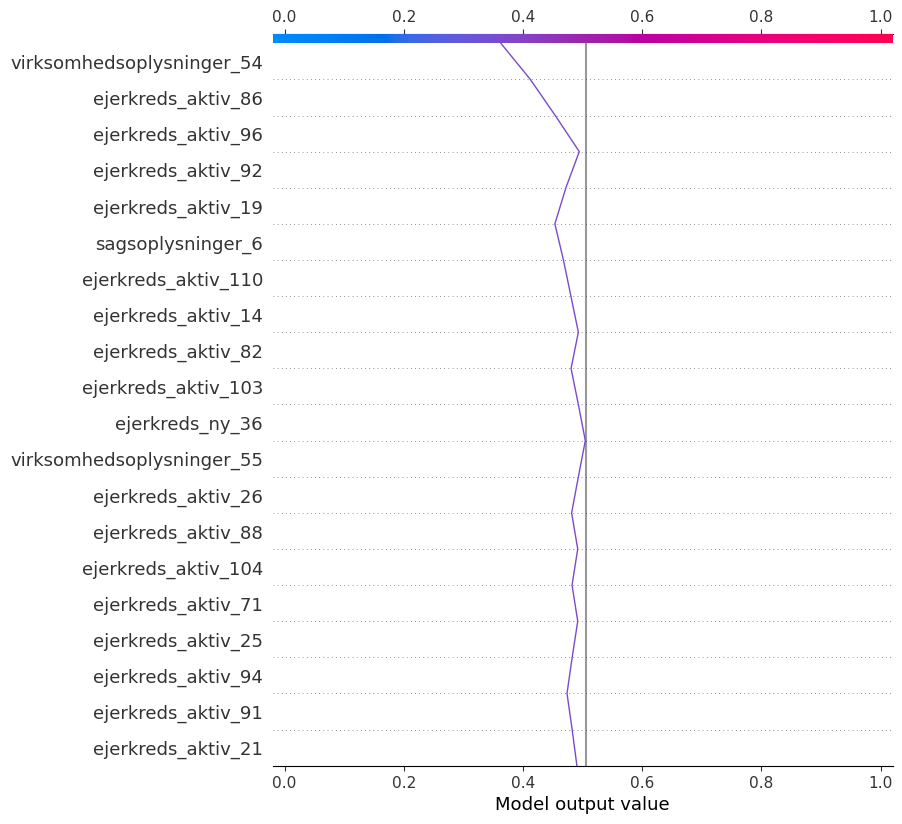

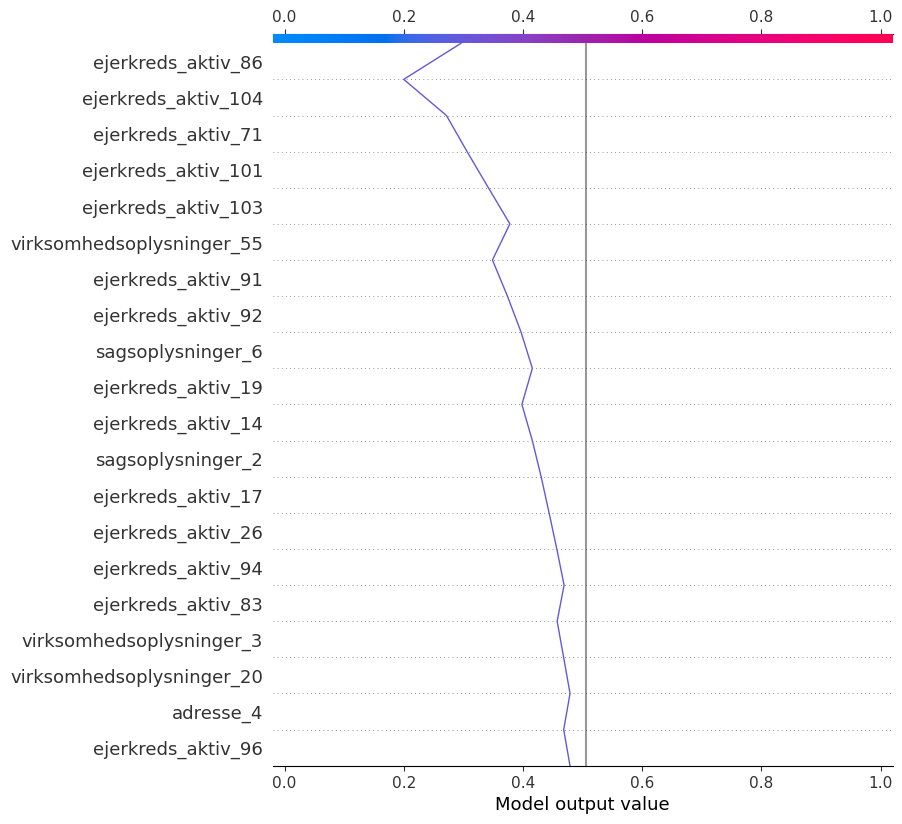

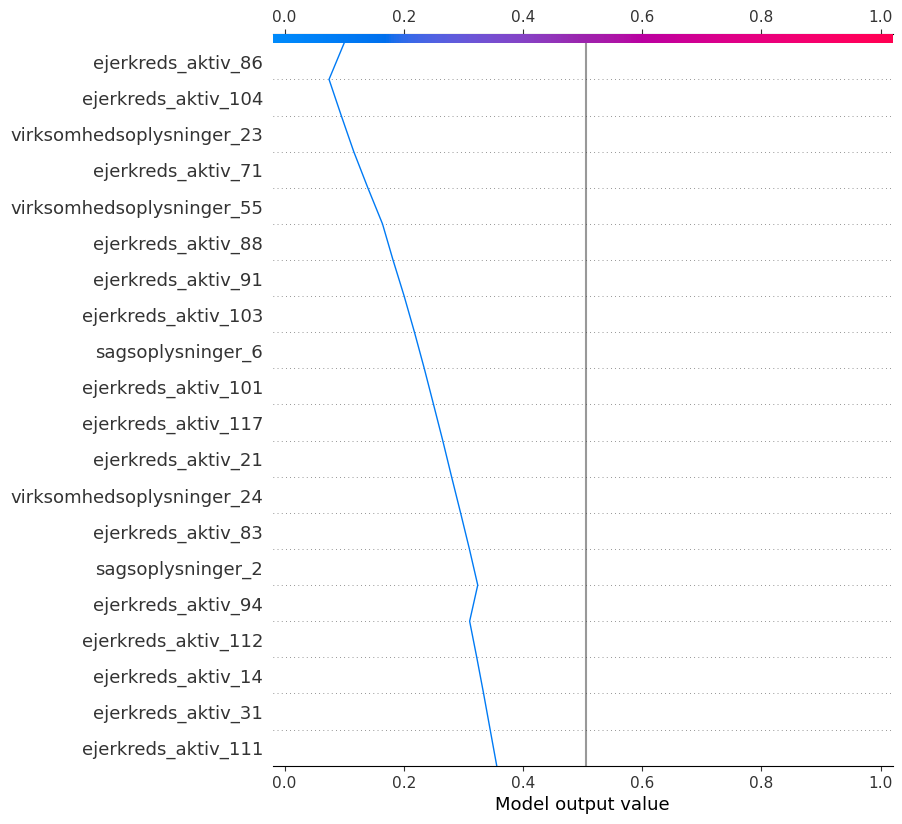

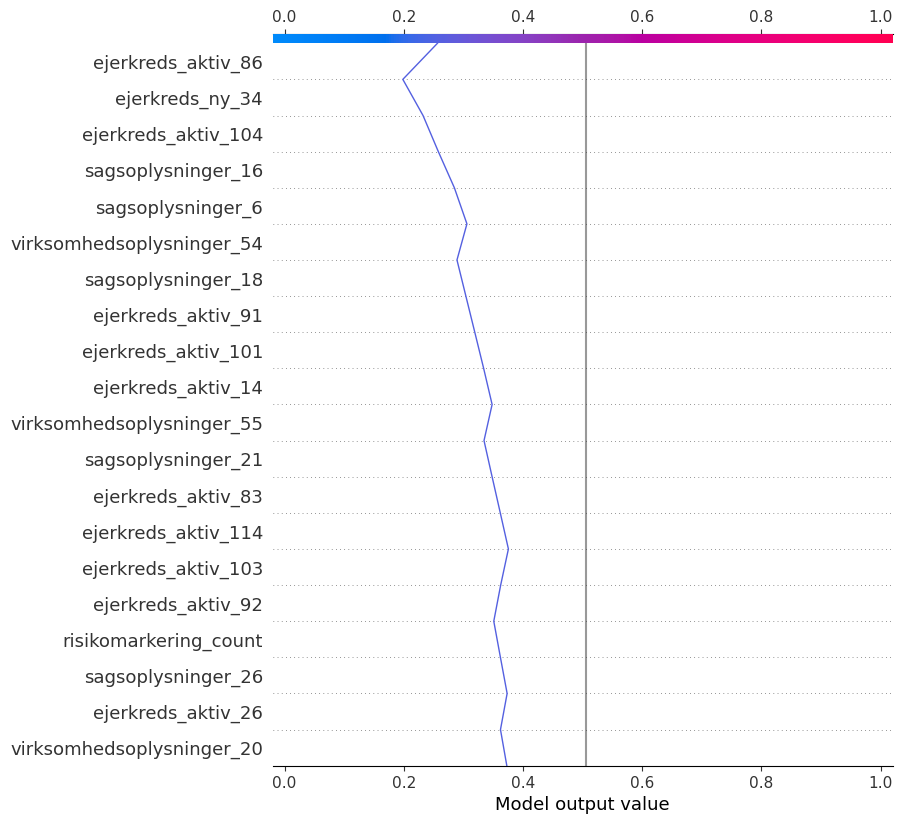

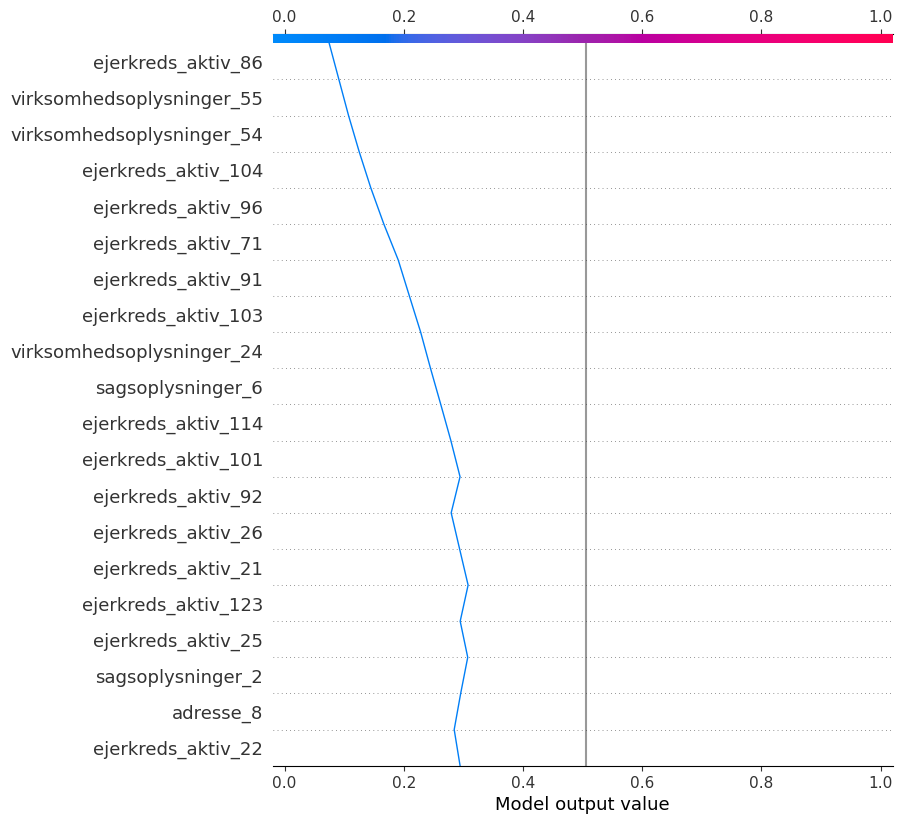

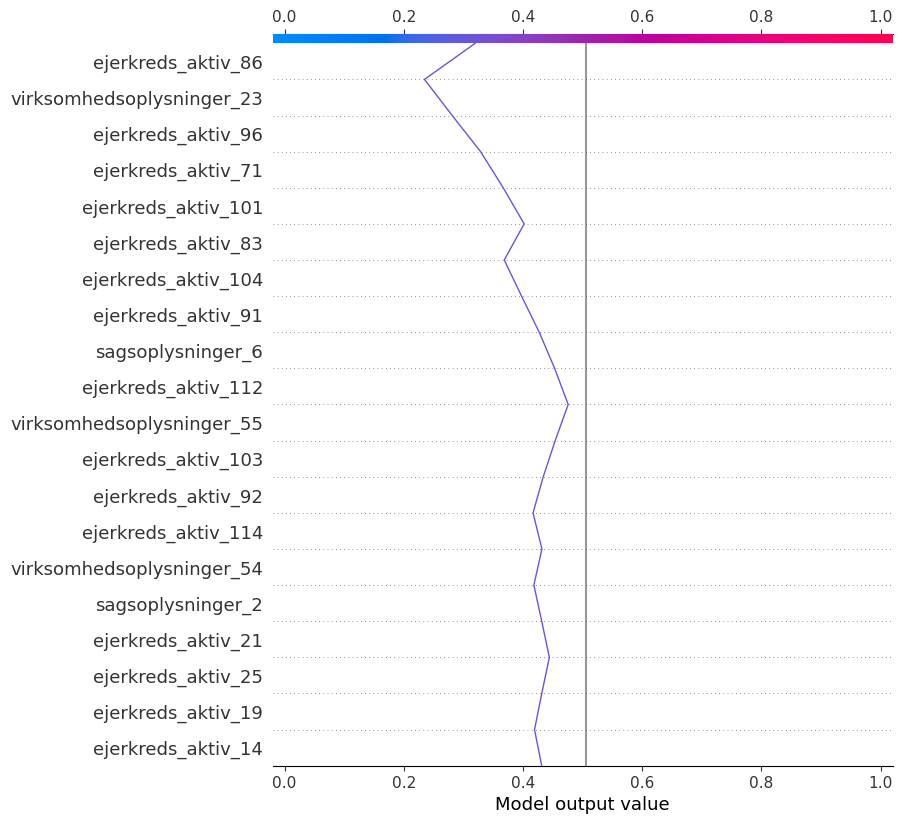

In [23]:
# Plot the decision plots for the 20 leaf nodes with the lowest impurity
for i, idx in enumerate(lowest_impurity_leaves):
    shap.plots.decision(expected_value, explainer.shap_values(X_val)[idx, :], features=X_val.columns.values, link='logit')
    plt.show()

In [25]:
lowest_gini_rows = class_probs.nsmallest(40, 'leaf_gini')
print(lowest_gini_rows)


      class_0   class_1  leaf_gini  leaf_indices  predicted  target
11   0.183148  0.816852        0.0         57954          1       0
13   0.631153  0.368847        0.0          6763          0       0
24   0.132081  0.867919        0.0         20704          1       1
25   0.839516  0.160484        0.0         44400          0       0
31   0.718757  0.281243        0.0         16613          0       0
35   0.532555  0.467445        0.0         48240          0       1
36   0.423278  0.576722        0.0         57908          1       0
38   0.807578  0.192422        0.0         61530          0       0
55   0.642527  0.357473        0.0         59509          0       0
59   0.765232  0.234768        0.0         41073          0       0
65   0.241240  0.758760        0.0         51952          1       0
69   0.554407  0.445593        0.0         12912          0       0
72   0.396951  0.603049        0.0         19196          1       0
75   0.267975  0.732025        0.0         21097

# The Boruta Feature Selection Algorithm 

Boruta gives a statistical answer to the following question: what is the threshold below which feature importance scores should be deemed so low that associated features ought to be useless?

To answer this question, Boruta creates new features called 'shadow features', which we know cannot possibly be useful to solve the problem at hand.

Typically, shadow features are constructed by shuffling each existing feature, thereby destroying any association between feature and target.

Formally, thanks to random shuffling, shadow features have the same marginal distributions as original features, but they are independent of the target both unconditionally and conditional on original features.

Because shadow features are useless, Boruta considers that no useful feature should have a feature importance score lower than that of a shadow feature.

An original feature is considered to have received a hit when its feature importance score is higher than the scores of all shadow features.

In essence, The Boruta algorithm treats the test as a Bernoulli trial. That is, Boruta applied a statistical hypothesis test to support feature selection.
Given that shadow features are randomly generated, we have a randomized control experiment with two outcomes, 'higher feature importance score than its shadow feature' 'not higher', that we can repeat k independent times, where we count the number of hits hi of each feature Xi. 

The Null Hypothesis H0

We represent the fact that we do not know whether feature xi is useful or not before running the test by saying that, in each of the k
k runs, there is a 50% chance that feature xi will receive a hit (i.e. a probability p=0.5
p=0.5).

Thus, in the absence of evidence pointing to whether xi is useful or not, hi should follow a Binomial distribution with rameters k and p. This forms the null hypothesis of the Boruta test.

The CDF of a Binomial distribution is well known and allows us to easily compute the two-sided symmetric confidence intervals [mq(k), Mq(k)] which hi should lie with q under Ho


The Alternate Hypothesis H1 

That Feature xi is UsefulWhen the number of hits hi  observed after k runs exceeds Mq(k) we reject the hypothesis H0, that we do not know whether feature xi is useful or not, in favor of the alternative H1  that feature xi is more likely to be useful than not.

The Alternate Hypothesis H2

That Feature xi is Useless When the number of hits hi observed after k runs is lower than mq(k) we reject the hypothesis H0 that we do not know whether feature xi is useful or not, in favor of the alternative H2that feature xi is more likely to be useless than not.